## Importation des librairies et transformation des données et création de la table des produits

In [2]:
import pandas as pd
import pickle as pk
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#Chargement du dataframe
df_customer = pd.read_csv('./csv/shopping_behavior_updated.csv', sep=";")

#On récupère l'ensemble des valeurs unique des produits
u_products = df_customer['Item Purchased'].str.split(', ', expand = True).stack().unique()

#On créer un dictionnaire qui représente la table d'achats des produits
data = {}

#On modifie la valeur stocké si le client a acheté ce produit
for i, row in df_customer.iterrows():
    items = row['Item Purchased'].split(', ')
    for item in items:
        if item not in data:
            data[item] = [0] * len(df_customer)
        data[item][i] += 1
df_product_table = pd.DataFrame(data)
df_product_table.to_csv('./csv/product_table.csv', sep=";", index=False)

print(df_product_table)

df_customer.drop(columns=['Item Purchased'], inplace=True)
df_customer.drop(columns=['Customer ID'], inplace=True)
df_customer.drop(columns=['Category'], inplace=True)
df_customer.drop(columns=['Purchase Amount (USD)'], inplace=True)
df_customer.drop(columns=['Previous Purchases'], inplace=True)
df_customer.drop(columns=['Color'], inplace=True)
df_customer.drop(columns=['Review Rating'], inplace=True)
df_customer.drop(columns=['Size'], inplace=True)

print(df_customer.head())

      Blouse  Sweater  Jeans  Sandals  Sneakers  Shirt  Shorts  Coat  Handbag  \
0          1        0      0        0         0      0       0     0        0   
1          0        1      0        0         0      0       0     0        0   
2          0        0      1        0         0      0       0     0        0   
3          0        0      0        1         0      0       0     0        0   
4          1        0      0        0         0      0       0     0        0   
...      ...      ...    ...      ...       ...    ...     ...   ...      ...   
3895       0        0      0        0         0      0       0     0        0   
3896       0        0      0        0         0      0       0     0        0   
3897       0        0      0        0         0      0       0     0        0   
3898       0        0      0        0         0      0       0     0        0   
3899       0        0      0        0         0      0       0     0        1   

      Shoes  ...  Hoodie  J

## Encodage des données

In [3]:
#Indexe des colonnes catégorielles (Gender,Location, Subscription Status, Frequency of Purchases)
cols_cat_info = [1,2,3,4,5,6,7,8,9]

#On créer une copie de notre dataframe source
df_grouped_customer = df_customer.copy()

#On supprime la colonne des achats

a_grouped_customer = df_grouped_customer.values
#Encodage des colonnes catégorielles
label_encoders_info = [LabelEncoder() for _ in range(len(cols_cat_info))]
for i, col_idx in enumerate(cols_cat_info):
    a_grouped_customer[:, col_idx] = label_encoders_info[i].fit_transform(a_grouped_customer[:, col_idx])

with open('./pickles/label_encoders_info_test.pkl', 'wb') as f:
    pk.dump(label_encoders_info, f)
#Print des données encodées
print(a_grouped_customer[0])



[55 1 16 1 3 3 1 1 1 5]


## Initialisation du modèle

In [4]:
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

a_product_table = df_product_table.values
print(a_grouped_customer[0])
#Initialisation du modèle
chained_model = RegressorChain(RandomForestRegressor(n_estimators=100, random_state=1), random_state=1)
chained_model.fit(a_grouped_customer, a_product_table)

y_pred = chained_model.predict(a_grouped_customer)
print("MSE : ",mean_squared_error(a_product_table, y_pred))
print(y_pred[0])

y_new_pred = chained_model.predict([[20, 2, 16, 1,1 , 2, 1,1, 1, 2]])
print(y_new_pred)

    

[55 1 16 1 3 3 1 1 1 5]
MSE :  0.005629907692307692
[0.69 0.01 0.   0.02 0.03 0.   0.01 0.01 0.01 0.   0.02 0.02 0.03 0.02
 0.03 0.01 0.   0.02 0.03 0.   0.   0.   0.03 0.01 0.01]
[[0.01 0.19 0.1  0.02 0.05 0.02 0.04 0.21 0.13 0.02 0.   0.01 0.   0.2
  0.09 0.15 0.07 0.04 0.02 0.12 0.05 0.09 0.35 0.13 0.35]]


## Calcul importance des variables


Index(['Age', 'Gender', 'Location', 'Subscription Status',
       'Frequency of Purchases', 'Season', 'Shipping Type', 'Discount Applied',
       'Promo Code Used', 'Payment Method'],
      dtype='object')
Liste des variables selon leur importance dans l'ordre décroissant
Age
Location
Shipping Type
Frequency of Purchases
Payment Method
Season
Gender
Subscription Status
Discount Applied
Promo Code Used


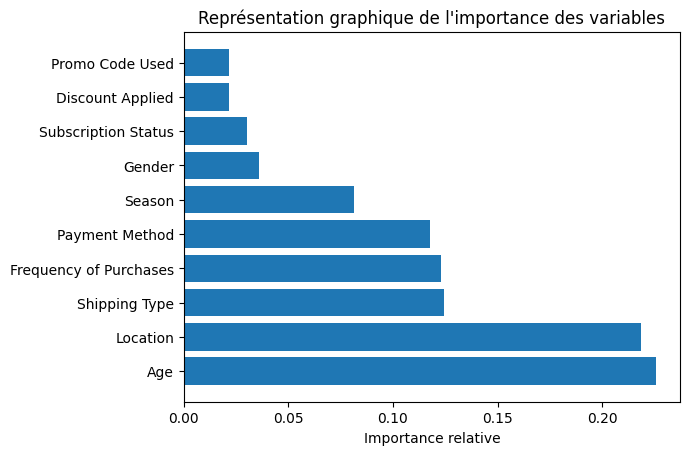

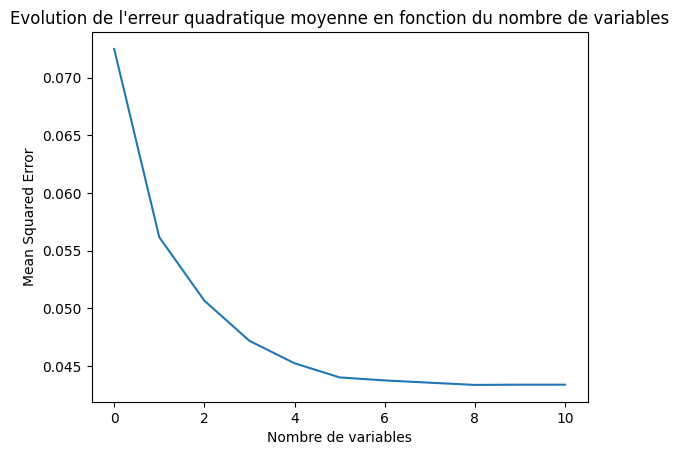

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Diviser les données en ensembles d'apprentissage et de test
x_train, x_test, y_train, y_test = train_test_split(a_grouped_customer, a_product_table, test_size=0.5, random_state=1)



# Entraîner un modèle RandomForestRegressor pour l'importance des caractéristiques
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(x_train, y_train)
importances = rf_regressor.feature_importances_


sorted_idx = np.argsort(importances)[::-1]
features = df_grouped_customer.columns

print(features)
# Afficher l'importance des variables
print("Liste des variables selon leur importance dans l'ordre décroissant")
for i in sorted_idx:
    print(features[i])

# Représentation graphique de l'importance des variables
padding = np.arange(x_train.size/x_train.shape[0]) + 0.5 
plt.barh(padding, importances[sorted_idx], align='center') 
plt.yticks(padding, features[sorted_idx]) 
plt.xlabel("Importance relative")
plt.title("Représentation graphique de l'importance des variables") 
plt.show()

# Entraîner un modèle MLPRegressor
mlp_regressor = chained_model = RegressorChain(RandomForestRegressor(n_estimators=100, random_state=1), random_state=1)
scores = np.zeros(x_train.shape[1] + 1)

# Evaluer l'accuracy en fonction du nombre de variables
for f in np.arange(0, x_train.shape[1] + 1):
    X1_f = x_train[:, sorted_idx[:f+1]]
    X2_f = x_test[:, sorted_idx[:f+1]]
    mlp_regressor.fit(X1_f, y_train)
    Y_pred = mlp_regressor.predict(X2_f)
    scores[f] = mean_squared_error(y_test, Y_pred)

# Afficher l'évolution de l'accuracy en fonction du nombre de variables
plt.plot(scores)
plt.xlabel("Nombre de variables")
plt.ylabel("Mean Squared Error")
plt.title("Evolution de l'erreur quadratique moyenne en fonction du nombre de variables")
plt.show()


## Recherche du meilleur modèle

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold
import numpy as np
import time

def run_regressor_chain_estimators(estimators, X, y):
    """
    Teste différents base estimators avec une RegressorChain et retourne les scores.

    Args:
    - estimators: Dictionnaire contenant les noms et les base estimators à tester.
    - X: Tableau NumPy des caractéristiques des clients.
    - y: Tableau NumPy des cibles (achats de produits).

    Returns:
    - best_estimator: Meilleur base estimator obtenu avec le score correspondant.
    """

    all_scores = []

    for clf_name, clf in estimators.items():
        start = time.time()

        # Créez le modèle RegressorChain avec le base_estimator actuel et spécifiez le nombre de folds
        chain = RegressorChain(base_estimator=clf, cv=10, random_state=1)
        chain.fit(X, y)
        predit = chain.predict(X)
        print("MSE for classifier ", clf_name , " is : ",mean_squared_error(y, predit))
        # Effectuez la validation croisée
        

        end = time.time()

        # Stockez les résultats dans all_scores
        all_scores.append([clf, mean_squared_error(y,predit), end- start])
        
        # Affichez les résultats pour le modèle actuel
        print(f"Base estimator: {clf_name}")
        print(f"Mean fit time:", end- start, " seconds")
        print("\n")


    # Trouvez le meilleur base estimator en fonction du score moyen
    all_scores.sort(key=lambda x: x[1], reverse=False)
    best_estimator = all_scores[0][0]
    best_score = all_scores[0][1]
    best_fit_time = all_scores[0][2]

    print("Best base estimator is:", best_estimator)
    print("with a mean MSE of =", best_score)
    print("and a mean fit time of =", best_fit_time, "seconds")

    return best_estimator

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Liste des base estimators à tester
base_estimators = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100,random_state=1, max_depth=5),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(random_state=1),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    'XGBRegressor': XGBRegressor(n_estimators=100,random_state=1),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100,random_state=1),
}

# Utilisez la fonction run_regressor_chain_estimators avec la liste de base estimators
best_estimator = run_regressor_chain_estimators(base_estimators, a_grouped_customer, a_product_table)


KeyboardInterrupt: 

## Recherche des meilleurs hyperparamètres

In [8]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(a_grouped_customer,a_product_table, test_size=0.4, random_state=1)  # random_state=1 ici

# Créer le modèle RegressorChain avec KNeighborsRegressor comme base estimator
base_estimator = KNeighborsRegressor()
chain_model = RegressorChain(base_estimator, random_state=1)

# Définir les hyperparamètres à optimiser
param_grid = {
    'base_estimator__n_neighbors': [3, 4, 5],
    'base_estimator__weights': ['uniform', 'distance'],
    'base_estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'base_estimator__leaf_size': [10, 20, 30]
}

# Initialiser la GridSearchCV avec random_state=1
grid_search = GridSearchCV(chain_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Effectuer la recherche sur grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score (neg_mean_squared_error):", grid_search.best_score_)

# Évaluer le modèle sur l'ensemble de test
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error sur l'ensemble de test:", mse)


Meilleurs paramètres: {'base_estimator__algorithm': 'ball_tree', 'base_estimator__leaf_size': 20, 'base_estimator__n_neighbors': 5, 'base_estimator__weights': 'uniform'}
Meilleur score (neg_mean_squared_error): -0.046287863247863166
Mean Squared Error sur l'ensemble de test: 0.0463476923076923


## Génération du pickle

In [10]:
model_to_pickle = RegressorChain(KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='ball_tree', leaf_size=20), random_state=1)
model_to_pickle.fit(a_grouped_customer, a_product_table)

with open('./pickles/predictionModelTest.pkl.pkl', 'wb') as f:
    pk.dump(model_to_pickle, f)

## Création de la fonction de prediction d'achats à partir de la prédiction du modèle

In [ ]:
df_customer = pd.read_csv('./csv/shopping_behavior_updated.csv', sep=";")

#On récupère l'ensemble des valeurs unique des produits
u_products = df_customer['Item Purchased'].str.split(', ', expand = True).stack().unique()

def predictedProduct(uniqueProduct, y_new_pred):
    products = y_new_pred[0]
    idProductRecommand = np.argsort((-products))
    list = [uniqueProduct[i] for i in idProductRecommand[:3]]
    return list

print(predictedProduct(u_products, y_new_pred))